In [10]:
# Import libraries
import torch
import numpy as np
from PIL import Image
from datasets import load_dataset 
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
import os
import time
import datasets
import aiohttp
from datasets import load_dataset, Features, Image as ImageFeature
import torch
import random
   

In [11]:
import sys
print(sys.path)

['/opt/anaconda3/envs/SCenv/lib/python310.zip', '/opt/anaconda3/envs/SCenv/lib/python3.10', '/opt/anaconda3/envs/SCenv/lib/python3.10/lib-dynload', '', '/opt/anaconda3/envs/SCenv/lib/python3.10/site-packages']


In [12]:
# Check for GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple GPU with Metal backend (MPS).")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using Apple GPU with Metal backend (MPS).


In [13]:

# Enable an emergency retry mechanism
os.environ["HF_HUB_ENABLE_EMERGENCY_RETRY"] = "True"
# Set a longer wait time between retries
os.environ["HF_HUB_EMERGENCY_RETRY_WAIT_TIME"] = "15" # Wait for 15 seconds


retry_attempts = 3

for attempt in range(retry_attempts):
    try:
        dataset_train = load_dataset("LaurenGurgiolo/9_Facial_Expressions", split = 'train')
        dataset_test = load_dataset("LaurenGurgiolo/9_Facial_Expressions", split = 'test')
        print("Dataset loaded successfully.")
       
        break
    except TimeoutError:
        print(f"Attempt {attempt + 1} failed, retrying...")
        if attempt < retry_attempts - 1:
            time.sleep(15)
        else:
            raise
dataset_train = dataset_train.shuffle(seed=42)
dataset_test = dataset_test.shuffle(seed=42)
print(dataset_train.shape) 
print(dataset_test.shape) 
id_to_emotion = {
    0: "0 Angry",
    1: "1 Contempt",
    2: "2 Disgust",
    3: "3 Fear",
    4: "4 Happy",
    5: "5 Neutral",
    6: '6 Sad',
    7: "7 Tired",
    8: "8 Surprised",
}
dataset_train


Resolving data files:   0%|          | 0/13433 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2146 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/13433 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2146 [00:00<?, ?it/s]

Dataset loaded successfully.
(13433, 2)
(2146, 2)


Dataset({
    features: ['image', 'label'],
    num_rows: 13433
})

In [5]:
print(dataset_train.column_names)

['image', 'label']


In [14]:
# 2. Configure the pretrained ViT model
# Load the pre-trained processor and model
model_name = "./vit-micro-facial-expressions"
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = ViTImageProcessor.from_pretrained(model_name)



# Check the number of labels in the dataset
# Adjust the model's classifier head for the new dataset
num_labels = len(dataset_train.features['label'].names)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)
model = model.to(device)

print(dataset_train.features['label'].names)
print(dataset_test.features['label'].names)
print(dataset_train)
dataset_train.features['label']
dataset_test.features['label']


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

['0 Anger', '1 Contempt', '2 Disgust', '3 Fear', '4 Happy', '5 Neutral', '6 Sadness', '7 Tired', '8 Surprise']
['0 Anger', '1 Contempt', '2 Disgust', '3 Fear', '4 Happy', '5 Neutral', '6 Sadness', '7 Tired', '8 Surprise']
Dataset({
    features: ['image', 'label'],
    num_rows: 13433
})


ClassLabel(names=['0 Anger', '1 Contempt', '2 Disgust', '3 Fear', '4 Happy', '5 Neutral', '6 Sadness', '7 Tired', '8 Surprise'])

In [15]:

# 1. Load the dataset
# Load a smaller split, like "validation", for faster testing


feature_extractor = ViTImageProcessor.from_pretrained(model_name)

# 3. Create a preprocessing function
# This function prepares a single example from the dataset for the model.
# It correctly applies the processor to the 'image' and 'label' columns.
# 3. Create a preprocessing function.
#    The `preprocess_example` function now accepts a dictionary (`example`) as input.
def preprocess_example(example):
    # This correctly extracts the image and label from the example dictionary.
    image = example['image']
    label = example['label']
    image = image.convert("RGB") 
    # Process the image with the feature extractor.
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    return {k: v.squeeze() for k, v in inputs.items()}

# 4. Apply the preprocessing function to the entire dataset using .map().
#    The `map` method passes each example (a dictionary) to the function.
processed_train = dataset_train.map(preprocess_example, batched=False)
processed_test = dataset_test.map(preprocess_example, batched=False)



# 5. Inspect a single processed example
# The output now contains the processed image ('pixel_values') and the label.
# The 'ValueError' is avoided because the unpacking is handled internally
# by the dataset's iteration, which expects a single dictionary from the transform function.

print(processed_train)
processed_test

Map:   0%|          | 0/13433 [00:00<?, ? examples/s]

Map:   0%|          | 0/2146 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 13433
})


Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 2146
})

In [8]:
# 4. Set up the Trainer and training arguments
# Define the training parameters
from torch.utils.data import DataLoader

# Assuming your custom dataset returns image tensors of shape (3, height, width)

training_args = TrainingArguments(
    output_dir="./vit-micro-facial-expressions2.2",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_dir='./logs_cosine_restarts',
    learning_rate=2e-5,
    warmup_steps=500,
    lr_scheduler_type="cosine_with_restarts", # Changed to cosine_with_restarts
    # Specify the number of cycles (restarts)
    lr_scheduler_kwargs={"num_cycles": 2}, 
    weight_decay=0.01,
    load_best_model_at_end=True, # Load the best model based on validation metric
    metric_for_best_model="accuracy",
    report_to="none",  
    push_to_hub=False, 
    # Set to True to push the model to Hugging Face Hub
)


In [9]:
# Define a function to compute evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate F1-score with a suitable average setting
    f1 = f1_score(labels, predictions, average='weighted') # Or 'micro', 'macro'

    # Calculate precision and recall similarly if needed
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}


In [10]:
# Initialize the Trainer


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= processed_train,
    eval_dataset=processed_test, # Assuming a 'test' split for evaluation
    compute_metrics=compute_metrics,
    
)




In [11]:
# 5. Train the model
print("Starting training...")
trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.737900,1.051123,0.644921,0.602675,0.668408,0.644921
2,0.403800,1.036685,0.704101,0.689103,0.739603,0.704101
3,0.161500,1.163030,0.726002,0.701487,0.762219,0.726002
4,0.082000,1.165055,0.743243,0.717657,0.773543,0.743243
5,0.123700,1.275086,0.734390,0.707190,0.775621,0.734390
6,0.057200,1.392390,0.742777,0.720153,0.795739,0.742777
7,0.019700,1.439144,0.734856,0.711551,0.788530,0.734856


TrainOutput(global_step=5880, training_loss=0.31128448142486365, metrics={'train_runtime': 8422.425, 'train_samples_per_second': 11.164, 'train_steps_per_second': 0.698, 'total_flos': 7.28710643097839e+18, 'train_loss': 0.31128448142486365, 'epoch': 7.0})

In [12]:
# 6. Evaluate the model on the test set
print("Evaluating the trained model...")
eval_results = trainer.evaluate()
print(eval_results)

Evaluating the trained model...


{'eval_loss': 1.1650553941726685, 'eval_accuracy': 0.7432432432432432, 'eval_f1': 0.7176566741140409, 'eval_precision': 0.7735434587111257, 'eval_recall': 0.7432432432432432, 'eval_runtime': 112.21, 'eval_samples_per_second': 19.125, 'eval_steps_per_second': 1.203, 'epoch': 7.0}


In [13]:
model.save_pretrained("./vit-micro-facial-expressions2.2")
processor.save_pretrained("./vit-micro-facial-expressions2.2")

['./vit-micro-facial-expressions2.2/preprocessor_config.json']

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Displaying images with predictions:
7
Image 1: True Label -> '7 Tired', Predicted Label -> '7 Tired'
4
Image 2: True Label -> '4 Happy', Predicted Label -> '4 Happy'
0
Image 3: True Label -> '0 Angry', Predicted Label -> '0 Angry'
4
Image 4: True Label -> '4 Happy', Predicted Label -> '4 Happy'
8
Image 5: True Label -> '8 Surprised', Predicted Label -> '8 Surprised'
0
Image 6: True Label -> '0 Angry', Predicted Label -> '0 Angry'
8
Image 7: True Label -> '8 Surprised', Predicted Label -> '8 Surprised'
4
Image 8: True Label -> '4 Happy', Predicted Label -> '8 Surprised'
7
Image 9: True Label -> '7 Tired', Predicted Label -> '7 Tired'
4
Image 10: True Label -> '4 Happy', Predicted Label -> '4 Happy'


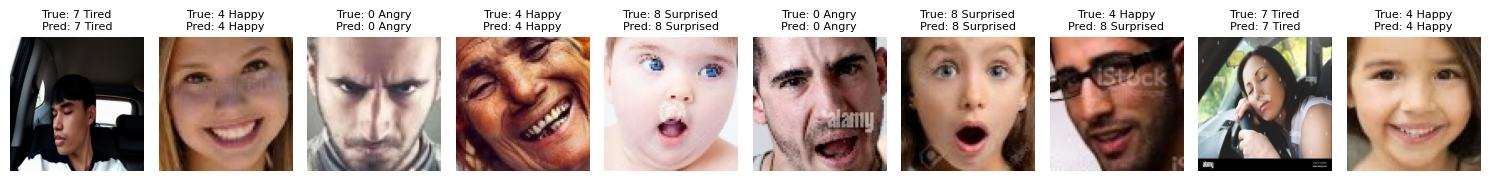

In [18]:
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
import matplotlib.pyplot as plt
model_name = "./vit-micro-facial-expressions2.2"


# Load the fine-tuned ViT model and its feature extractor
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.eval()


num_images_to_display = 10
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

print("Displaying images with predictions:")
for i in range(num_images_to_display):
    # Select a random image from the dataset
    sample = processed_test[i]
    image = sample['image']
    true_label_id = sample['label']
    image = image.convert("RGB") 
    print(true_label_id)
    

    # Preprocess the image for the ViT model
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label_id = logits.argmax(-1).item()

    # Get the true and predicted labels as strings
    
    true_label = id_to_emotion[true_label_id]
    predicted_label = id_to_emotion[predicted_label_id ]
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8)
    axes[i].axis('off')

    print(f"Image {i+1}: True Label -> '{true_label}', Predicted Label -> '{predicted_label}'")

plt.tight_layout()
plt.show()

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Filter:   0%|          | 0/2146 [00:00<?, ? examples/s]

Image shape before LIME: (80, 80, 3), Image dtype before LIME: uint8


  0%|          | 0/1000 [00:00<?, ?it/s]

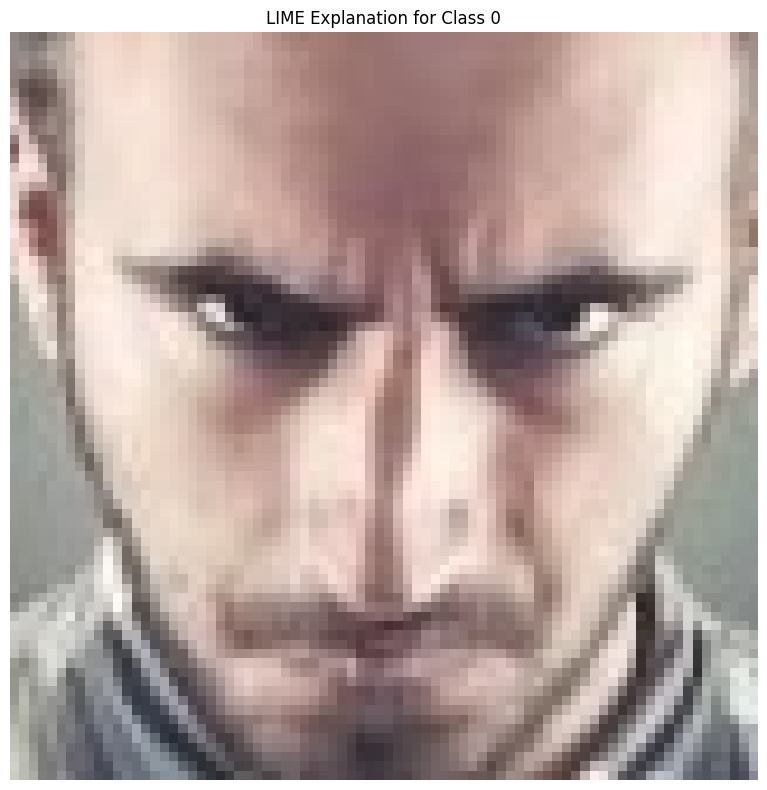

In [20]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import requests
from transformers import ViTForImageClassification, ViTImageProcessor
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

model_name = "./vit-micro-facial-expressions2.2"



# Load the fine-tuned ViT model and its feature extractor
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.eval()


model.to(device)



# 2. Define the prediction function for LIME
def huggingface_predict(processed_test):
    """
    LIME requires a prediction function that takes a list of images (numpy arrays)
    and returns a numpy array of prediction probabilities for each class.
    """
    
    pil_images = []
    for img_array in processed_test:
        # Ensure input is a standard NumPy array and convert data type if needed
        if not isinstance(img_array, np.ndarray):
            # This should not happen if LIME works as intended, but is a safeguard
            print(f"Warning: Non-numpy input type: {type(img_array)}")
            continue
            
        # If the image array is a float (common from LIME), scale to 0-255 for PIL conversion if necessary
        if img_array.dtype == np.float32 or img_array.dtype == np.float64:
            # Scale float images (0.0-1.0) to ubyte (0-255) for standard PIL handling
            img_array = (img_array * 255).astype(np.uint8)

        # Check and handle unusual shapes (e.g., singleton dimensions if they appear)
        if img_array.ndim == 4 and img_array.shape[0] == 1:
            img_array = np.squeeze(img_array, axis=0)
            
        # Ensure 3 channels (RGB)
        if img_array.shape[-1] != 3:
            # Handle non-RGB images if necessary (e.g., grayscale or RGBA conversion)
            if img_array.shape[-1] == 4: # RGBA -> RGB
                 img_array = img_array[..., :3]
            else:
                # Handle grayscale or other formats by converting to RGB
                # You might need a more robust conversion here based on your data
                img_array = Image.fromarray(img_array).convert('RGB')
                img_array = np.array(img_array)
                
        try:
            pil_images.append(Image.fromarray(img_array))
        except TypeError as e:
            print(f"Error converting array to PIL Image: {e}")
            print(f"Array shape: {img_array.shape}, dtype: {img_array.dtype}")
            continue

    if not pil_images:
        # Return empty probabilities if no images could be processed
        return np.zeros((len(processed_test), model.config.num_labels))

    
    # Preprocess the batch of images
    inputs = feature_extractor(images=pil_images, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to device

    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get probabilities (softmax)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Return as numpy array
    return probabilities.cpu().numpy()
# 3. Load an image

# 4. Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# 5. Generate the explanation for a specific instance
# num_samples: number of perturbed images LIME creates

from skimage import img_as_ubyte, img_as_float
import numpy as np

def filter_four_channel_images(example):
    # Access the image from the specified column (e.g., 'image')
    image = example['image']

    # Convert to numpy array to easily check shape
    # The shape for an image is typically (height, width, channels)
    image_array = np.array(image)

    # Check if the image has more than 3 channels (e.g., RGBA or multi-band)
    # If the image has > 3 channels, return False to filter it out
    if image_array.shape[-1] > 3:
        return False
    # Otherwise, return True to keep the image
    return True

processed_test= processed_test.filter(filter_four_channel_images)

# Note: Depending on your dataset, the image might already be a numpy array. 
# Adjust the channel check accordingly (e.g., image.shape[-1])

image = processed_test[2]
image = image['image']

from torchvision import transforms
from PIL import Image

if isinstance(image, Image.Image):
    image = image.convert('RGB')
    # Convert PIL Image to NumPy array and ensure correct type/range
    # LIME often expects 0-255 uint8 images internally unless specified otherwise
    # or float 0-1 images if img_as_float is used
    image_np = np.array(image) 
elif isinstance(image, np.ndarray):
    # Ensure numpy array has 3 channels if it came from a different source
    if image.shape[-1] == 1:
        image = Image.fromarray(image.squeeze(), 'L').convert('RGB')
        image_np = np.array(image)
    elif image.shape[-1] == 3:
        image_np = image
    else:
        raise ValueError("Image has an unsupported number of channels.")

# *** FIX: Use 8-bit image for LIME input to ensure compatibility with Lab conversion ***
# If your image is float (0-1), convert it to uint8 (0-255)
if image_np.dtype == np.float32 or image_np.dtype == np.float64:
    image_processed = img_as_ubyte(image_np)
else:
    image_processed = image_np

if len(image_processed.shape) == 4 and image_processed.shape[0] == 1 and image_processed.shape[1] == 1:
    image_processed = image_processed.squeeze() # Removes dimensions of size 1


print(f"Image shape before LIME: {image_processed.shape}, Image dtype before LIME: {image_processed.dtype}")



# *** FIX 2 (Alternative): Ensure the image is a float scaled between 0 and 1 ***
# This assumes your image values are already in the 0-1 range.
# If they are in 0-255, you must scale them first (e.g., image / 255)
# image_processed = img_as_float(image)

try:
    explanation = explainer.explain_instance(
        image_processed,  # Use the processed image
        huggingface_predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )
    # ... (rest of your visualization code) ...

    
    # 6. Visualize the explanation
    # Get the image and mask for the top predicted class
    top_pred_label = explanation.top_labels[0]
    temp_1, mask_1 = explanation.get_image_and_mask(
        top_pred_label,
        positive_only=True,
        num_features=5, # Top 5 features (superpixels) contributing to the prediction
        hide_rest=True
    )
    from skimage import img_as_float

# Convert the temporary image array to float format suitable for mark_boundaries
# If the input image_processed was uint8, temp will be too.
# mark_boundaries documentation often assumes float input.
    # Normalize the input image to ensure it's in a valid range [0, 1] for mark_boundaries if it's currently 0-255 float:
    if temp_1.dtype == np.float32 or temp_1.dtype == np.float64:
    # Check if range is [0, 1] or [0, 255]
        if temp_1.max() > 1.01: # Assuming max > 1 means it's 0-255 scale float
        # Cast to uint8 (standard image format for plotting)
            temp_1_plot = temp_1.astype(np.uint8) 
        else:
        # Range is likely [0, 1], keep as float
            temp_1_plot = temp_1
    else:
    # Already integer type
        temp_1_plot = temp_1

# Use mark_boundaries on the original *normalized* image for proper overlay
# The original 'img_numpy' is uint8. mark_boundaries expects floats between [0, 1] for its first argument.
    img_numpy_normalized = image_processed.astype(float) / 255.0
   
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

# mark_boundaries expects img_numpy_normalized to be float [0, 1]
# temp_1_plot is the masked image data (uint8 0-255)

# The fix: Ensure all inputs to imshow and mark_boundaries are correctly typed and ranged.
    ax1.imshow(mark_boundaries(img_numpy_normalized, mask_1)) 
    ax1.set_title(f'LIME Explanation for Class {top_pred_label}')
    ax1.axis('off')
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Error processing image: {e}")